In [1]:
# Install XGBoost, TensorFlow, SageMaker Python SDK and NumPy
!pip install xgboost
!pip install sagemaker
!pip install tensorflow
!pip install numpy

In [2]:
# Import all necessary libraries and packages
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight

import xgboost as xgb
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.inputs import TrainingInput
from sagemaker.xgboost import XGBoost
from sagemaker.session import Session

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

2024-05-27 14:45:39.743563: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 14:45:42.365292: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
# Load in the dataset
df= pd.read_csv('/home/ec2-user/SageMaker/diabetes-readmission-prediction/updated_diabetes_data.csv')

In [4]:
# View the data
df.head(10)

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesmed,readmitted
0,8057670,96198543,?,Female,[80-90),6,5,17,9,?,...,No,Steady,No,No,No,No,No,Ch,Yes,>30
1,8042082,94466574,Caucasian,Male,[50-60),6,1,17,2,?,...,No,Steady,No,No,No,No,No,No,Yes,>30
2,8235036,79874631,Caucasian,Female,[60-70),6,1,17,5,?,...,No,Steady,No,No,No,No,No,Ch,Yes,>30
3,8274126,90421380,Caucasian,Female,[40-50),6,1,17,3,?,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
4,8421486,55628172,Caucasian,Female,[70-80),6,6,17,11,?,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,8576406,80041266,Caucasian,Female,[80-90),6,1,17,9,?,...,No,Steady,No,No,No,No,No,Ch,Yes,>30
6,8620524,93126573,Caucasian,Female,[50-60),6,1,17,6,?,...,No,No,No,No,No,No,No,No,No,>30
7,8753532,10648701,Caucasian,Male,[70-80),6,3,17,6,?,...,No,No,No,No,No,No,No,No,Yes,NO
8,8866632,103586670,Caucasian,Male,[70-80),6,1,17,6,?,...,No,Steady,No,No,No,No,No,No,Yes,>30
9,9089646,42912702,Caucasian,Female,[60-70),6,1,17,7,?,...,No,Steady,No,No,No,No,No,Ch,Yes,>30


In [5]:
# Explore the data
df.shape

(101766, 47)

In [6]:
# Explore the data
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'examide', 'citoglipton', 'insulin', 'glyburide_metformin',
       'glipizide_metformin', 'glimepiride_pioglitazone',
       'metformin_rosiglitazone', 'metformin_pioglitazone', 'change',
       'diabetesmed', 'readmitted'],
      dtype='object')

In [7]:
# Double check for missing values
missing_values= df.isnull().sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

In [8]:
# Display summary statistics for numeric columns
numeric_summary= df.describe()
print(numeric_summary)

       encounter_id   patient_nbr  admission_type_id  \
count  1.017660e+05  1.017660e+05      101766.000000   
mean   1.652016e+08  5.433040e+07           2.024006   
std    1.026403e+08  3.869636e+07           1.445403   
min    1.252200e+04  1.350000e+02           1.000000   
25%    8.496119e+07  2.341322e+07           1.000000   
50%    1.523890e+08  4.550514e+07           1.000000   
75%    2.302709e+08  8.754595e+07           3.000000   
max    4.438672e+08  1.895026e+08           8.000000   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
count             101766.000000        101766.000000     101766.000000   
mean                   3.715642             5.754437          4.395987   
std                    5.280166             4.064081          2.985108   
min                    1.000000             1.000000          1.000000   
25%                    1.000000             1.000000          2.000000   
50%                    1.000000             7.00000

**Analysis of the Diabetes Dataset for Numeric Columns**

The dataset comprises information from 101,766 encounters, each represented by a unique encounter_id and patient_nbr. These identifiers serve as unique keys, ensuring each record is distinct.

A significant aspect of the dataset is the distribution of admission_type_id, with a mean value of 2.02. The majority of admissions fall under the lower-numbered categories, with the median value being 1, indicating that the most frequent admission type is category 1. Similarly, the discharge_disposition_id shows a mean of 3.72, but the median value is 1, suggesting that most discharges fall under category 1. The admission_source_id reveals a variety of admission sources, with a median value of 7, pointing to category 7 as a common source.

The average length of stay in the hospital (time_in_hospital) is approximately 4.40 days, with a median of 4 days, indicating that half of the patients stay for four days or less. This is coupled with a high number of lab procedures per encounter, with an average of 43 procedures and a median of 44, showing that extensive testing is typical for these patients.

Patients typically undergo about one procedure (num_procedures), and the average number of medications prescribed (num_medications) is 16, highlighting the complexity of managing diabetes, which often involves multiple medications. Despite the high average, the number of outpatient (number_outpatient), emergency (number_emergency), and inpatient visits (number_inpatient) are relatively low, with most patients not having these visits. However, the variability in these counts suggests that a subset of patients experiences frequent visits.

The dataset also reveals a high number of diagnoses per patient, with an average of 7.42 diagnoses, underscoring the multifaceted nature of diabetes and its associated conditions.

The dataset highlights the extensive medical interactions and complex management required for diabetic patients, with multiple medications and frequent lab procedures being the norm. The dominance of specific admission types, discharge dispositions, and admission sources will be crucial areas for further analysis. Understanding these patterns will be essential for predicting readmission rates and improving patient outcomes.

In [9]:
# Display summary statistics for categorical columns
categorical_summary= df.describe(include= [object])
print(categorical_summary)

             race  gender      age payer_code medical_specialty  diag_1  \
count      101766  101766   101766     101766            101766  101766   
unique          6       3       10         18                73     717   
top     Caucasian  Female  [70-80)          ?                 ?     428   
freq        76099   54708    26068      40256             49949    6862   

        diag_2  diag_3 metformin repaglinide  ... citoglipton insulin  \
count   101766  101766    101766      101766  ...      101766  101766   
unique     749     790         4           4  ...           1       4   
top        276     250        No          No  ...          No      No   
freq      6752   11555     81778      100227  ...      101766   47383   

       glyburide_metformin glipizide_metformin glimepiride_pioglitazone  \
count               101766              101766                   101766   
unique                   4                   2                        2   
top                     No       

**Analysis of the Diabetes Dataset for Categorical Columns**

The categorical summary of the diabetes dataset reveals several key insights into the patient demographics and medical characteristics. The dataset includes six unique races, with Caucasians forming the majority at 76,099 instances. Gender distribution shows a higher frequency of females, accounting for 54,708 records. The age distribution is divided into ten categories, with the most common age group being 70-80 years, comprising 26,068 patients.

A significant portion of the dataset has missing or unspecified values in the payer_code and medical_specialty columns, marked by the top value '?', appearing 40,256 and 49,949 times, respectively. This indicates a need for careful handling of these missing values during analysis.

In terms of diagnoses, there is a substantial variety, with diag_1 having 717 unique codes, diag_2 having 749, and diag_3 having 790. The most frequent primary diagnosis code (428) appears 6,862 times.

Medication use is also diverse, though the top value for all medications is 'No', indicating that many patients are not on these specific medications. For instance, 81,778 records indicate no use of metformin, and 100,227 indicate no use of repaglinide. However, insulin usage is significant, with 47,383 instances, which is to be expected for diabetes patients.

Most patients have not experienced changes in their medication regimens (change column), and the majority are on diabetes medication (diabetesMed column), with 78,363 records indicating 'Yes'.

The readmitted column, which is crucial for our prediction goal, shows three unique values with 'NO' being the most frequent, appearing 54,864 times.

These insights highlight the need for targeted analysis and feature engineering, especially in handling missing values and understanding the impact of various demographic and medical features on readmission rates. The prevalence of certain diagnoses, the extensive non-use of many medications, and the high rate of specific readmission outcomes will be critical in building predictive models.

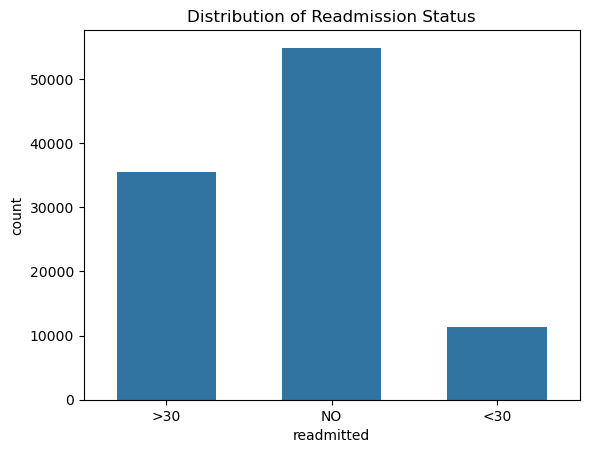

In [10]:
# Distribution of target feature (readmitted)
sns.countplot(data= df, x= 'readmitted', width= 0.6)
plt.title('Distribution of Readmission Status')
plt.show()

**Distribution of Readmission Status**

The bar chart displaying the distribution of readmission status among patients reveals a significant imbalance. The majority of patients were not readmitted (labeled as "NO"), with approximately 54,864 instances. This is followed by patients readmitted after more than 30 days ("">30"), accounting for around 35,000 instances. The smallest group consists of patients readmitted within 30 days ("<30"), with approximately 11,902 instances. This imbalance in the target variable indicates that most patients did not experience readmission, and only a smaller fraction were readmitted within the 30-day window, which is crucial for our prediction goal. Addressing this imbalance will be essential in the subsequent steps of model development to ensure the model's effectiveness and reliability in predicting readmissions.

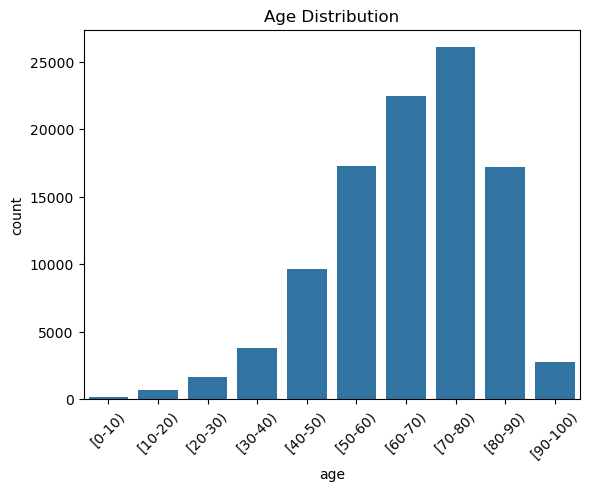

In [11]:
# Define the order of the age categories
age_order= ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']

# Distribution of Age
sns.countplot(data= df, x= 'age', order= age_order)
plt.title('Age Distribution')
plt.xticks(rotation= 45)
plt.show()

**Age Distribution**

The age distribution chart indicates that the majority of patients in the dataset are older adults, with the most represented age groups being 70-80 and 60-70, comprising around 26,000 and 23,000 patients, respectively. This is followed by the 50-60 age group, with approximately 17,000 patients. The youngest age groups (e.g., 0-10, 10-20, and 20-30) have very few patients, suggesting that the dataset predominantly includes older individuals. This age distribution aligns with the typical demographic for diabetes patients, who are more likely to be older adults. Understanding this age distribution is crucial for tailoring the predictive model and potential interventions to the demographic most at risk of readmission.

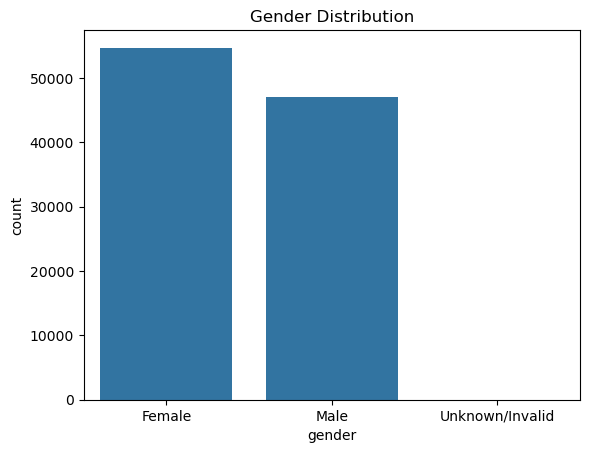

In [12]:
# Distribution of Gender
sns.countplot(data= df, x= 'gender')
plt.title('Gender Distribution')
plt.show()

**Gender Distribution Chart**

The gender distribution chart reveals that the dataset consists predominantly of female patients, making up a slight majority compared to male patients. Specifically, there are slightly more female patients than male patients. Additionally, there is a small category labeled "Unknown/Invalid," indicating some entries with missing or invalid gender information. This distribution suggests that while the dataset is fairly balanced between male and female patients, any analysis or modeling should consider the presence of entries with unspecified gender, which may need to be handled appropriately during data preprocessing.

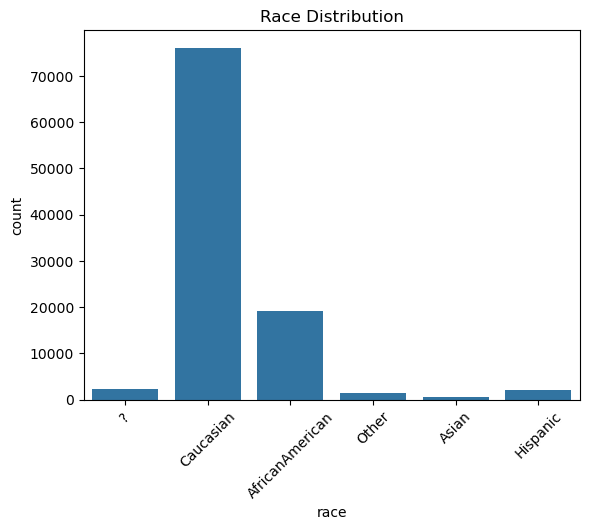

In [13]:
# Race Distribution
sns.countplot(data= df, x= 'race')
plt.title('Race Distribution')
plt.xticks(rotation= 45)
plt.show()

**Race Distribution Chart**

The race distribution chart highlights a significant predominance of Caucasian patients in the dataset, constituting the majority by a large margin. African American patients form the second-largest group but are considerably fewer in number compared to Caucasian patients. The categories 'Other,' 'Asian,' and 'Hispanic' are represented minimally, indicating a less diverse dataset. Additionally, there is a small portion of entries with unspecified race labeled as '?'. This imbalance suggests that the dataset may not fully represent the diversity of the broader population, and any analysis or modeling should account for this skew to ensure generalizability and fairness.

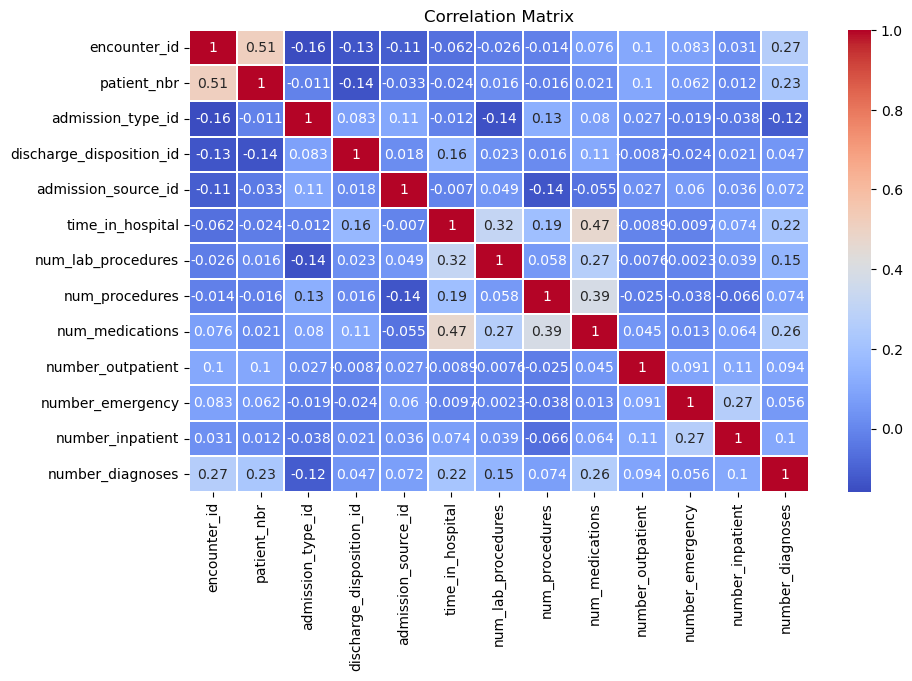

In [14]:
# Select only numeric columns for correlation matrix
numeric_df= df.select_dtypes(include= ['number'])

# Heatmap of correlations of numeric features
plt.figure(figsize= (10,6))
correlation_matrix= numeric_df.corr()
sns.heatmap(correlation_matrix, annot= True, cmap= 'coolwarm', linewidths= 0.2)
plt.title('Correlation Matrix')
plt.show()

**Correlation Matrix**

The correlation matrix provides insights into the relationships between various numeric features in the dataset. The highest positive correlations are observed between num_medications and number_inpatient (0.39), as well as num_medications and number_outpatient (0.27), indicating that patients with more medications tend to have more inpatient and outpatient visits. Additionally, time_in_hospital shows a moderate correlation with num_lab_procedures (0.32) and num_medications (0.47), suggesting that longer hospital stays are associated with more lab procedures and medications. Most other correlations are relatively low, indicating that there are no strong linear relationships between the majority of numeric features. This suggests that a combination of multiple features will likely be necessary to build an effective predictive model for hospital readmission.

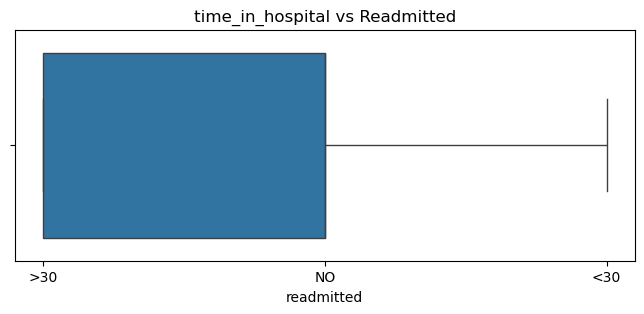

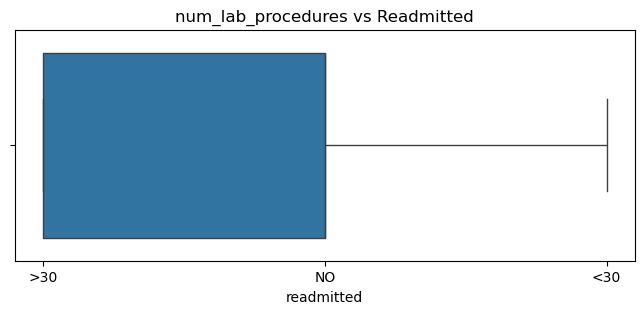

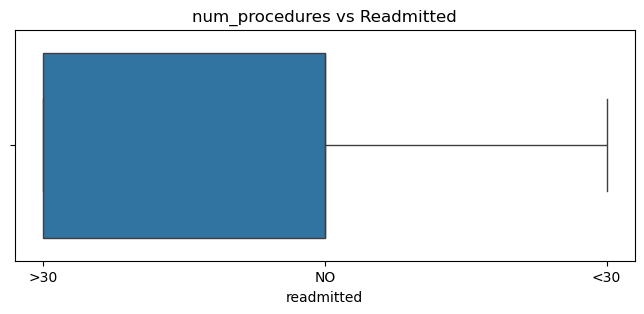

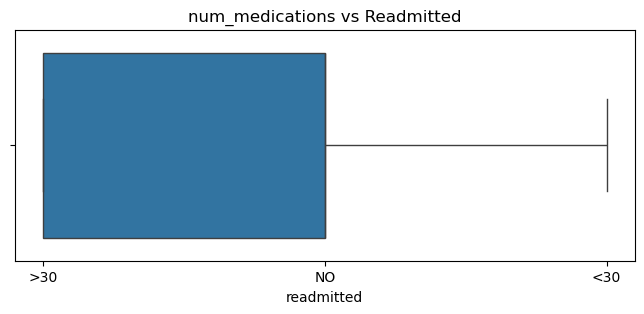

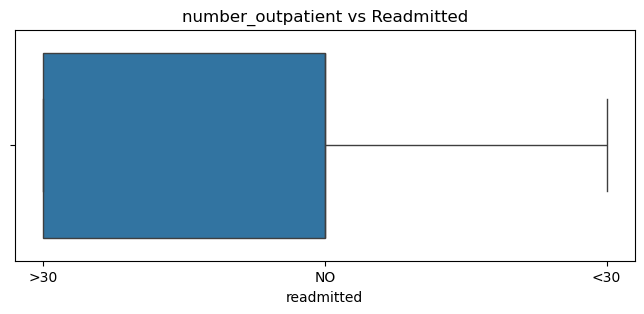

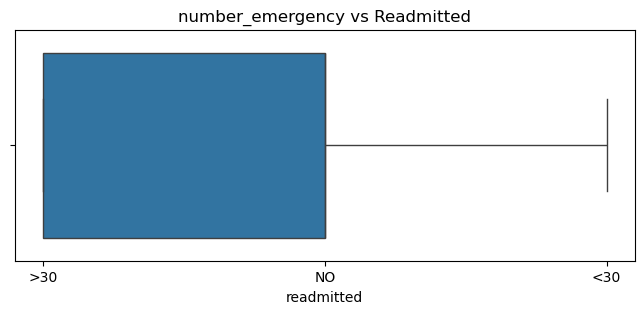

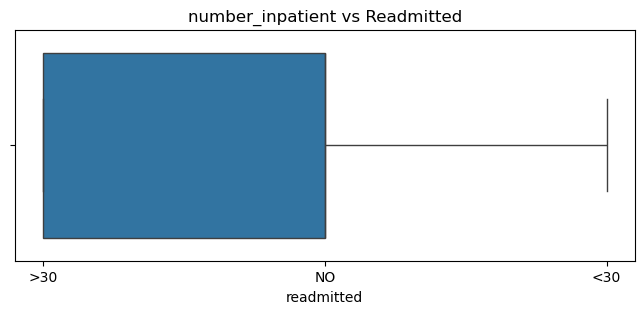

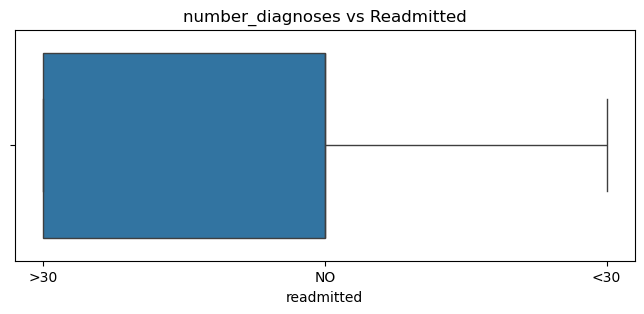

In [15]:
# Boxplot for numeric features vs. 'readmitted'
numeric_columns= ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
                  'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

for col in numeric_columns:
    plt.figure(figsize= (8,3))
    sns.boxplot(data= df, x= 'readmitted')
    plt.title(f'{col} vs Readmitted')
    plt.show()

**Boxplots**

The boxplots provide a visual summary of the distribution of various numeric features in relation to the readmission status of patients. Here are the key insights:

1. Time in Hospital vs. Readmitted:
The median time in the hospital is consistent across different readmission statuses. Patients who are not readmitted tend to have a shorter hospital stay compared to those readmitted within 30 days or after 30 days.

2. Num Lab Procedures vs. Readmitted:
The number of lab procedures does not show a significant difference across different readmission statuses. The distribution is fairly consistent, indicating that the number of lab procedures might not be a strong indicator of readmission.

3. Num Procedures vs. Readmitted:
Similar to lab procedures, the number of procedures does not vary significantly across different readmission statuses. This suggests that the number of procedures is not a major factor in predicting readmission.

4. Num Medications vs. Readmitted:
The number of medications shows a slight increase for patients not readmitted compared to those readmitted within 30 days. This might indicate that better medication management could potentially reduce the chances of early readmission.

5. Number Outpatient vs. Readmitted:
The number of outpatient visits appears higher for patients not readmitted, suggesting that regular outpatient follow-ups might help in reducing readmissions.

6. Number Emergency vs. Readmitted:
The number of emergency visits shows a wider range for patients not readmitted, indicating that those not readmitted might have had more emergency visits managed effectively.

7. Number Inpatient vs. Readmitted:
The number of inpatient stays is slightly higher for patients readmitted within 30 days, suggesting a potential correlation between inpatient frequency and readmission risk.

8. Number Diagnoses vs. Readmitted:
The number of diagnoses is higher for patients readmitted within 30 days, which could indicate that patients with more diagnoses are at a higher risk of early readmission.

These insights provide a foundation for understanding which features may influence patient readmission and guide further feature engineering and model development.

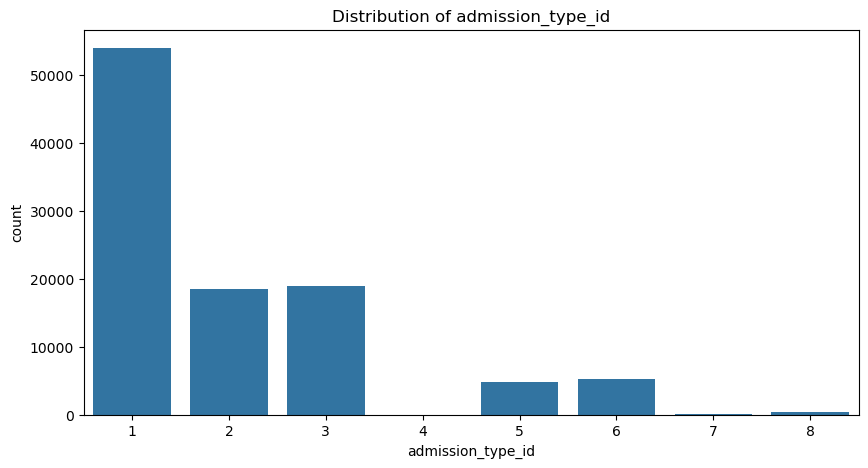

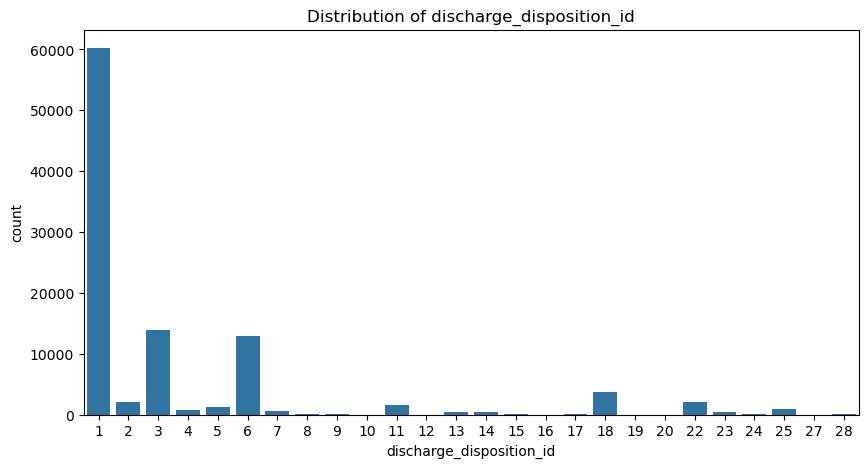

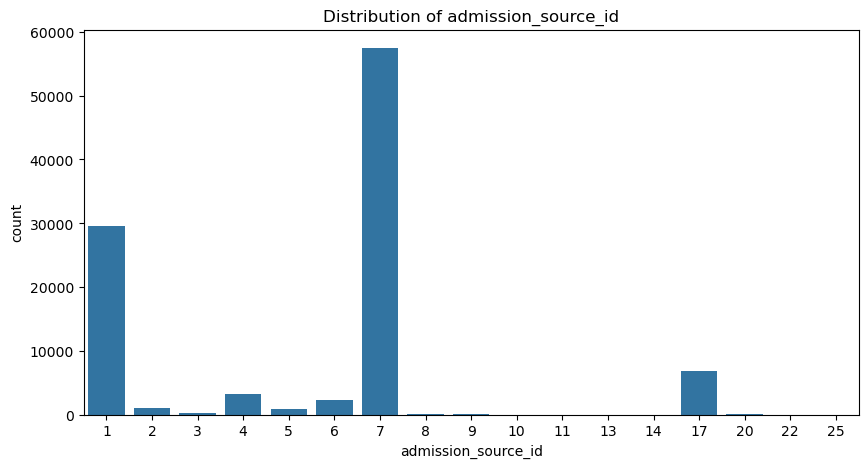

In [16]:
# Distribution of admission type, discharge disposition and admission source
cat_columns= ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']

for col in cat_columns:
    plt.figure(figsize= (10,5))
    sns.countplot(data= df, x= col)
    plt.title(f'Distribution of {col}')
    plt.show()

**Distribution of Admission Type, Discharge Disposition and Admission Source**

The charts for admission_type_id, discharge_disposition_id, and admission_source_id provide important insights into the dataset's composition and patient flow within the hospital system.

1. Admission Type Distribution: The majority of admissions are of type 1, which is likely to be emergency admissions, indicating that most patients are admitted under urgent circumstances. Other admission types such as 2 and 3 also have significant counts, representing elective and other scheduled admissions.

2. Discharge Disposition Distribution: A large proportion of patients are discharged to home (1), followed by discharge to home with home health care (6). The high count for discharged to home suggests that many patients recover sufficiently to go back to their homes without additional healthcare services.

3. Admission Source Distribution: Most admissions come from the emergency room (7), followed by physician referral (1). This highlights the role of the emergency room as a primary entry point for patients, with a significant number also being referred by healthcare professionals.

These distributions highlight the emergency-driven nature of hospital admissions in this dataset and the prevalent discharge practices, which are crucial for understanding patient flow and resource allocation in the hospital setting.

In [17]:
# Define categorical and numerical columns
categorical_features= ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id']
numerical_features= ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

In [38]:
# Apply transformations
X = df.drop('readmitted', axis=1)
y = df['readmitted']

In [41]:
# Label encoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Now split the data with the encoded labels
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [42]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize the XGBoost classifier
xgb = XGBClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

In [43]:
# Fit the model
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.1, 0.01], 'max_depth': [3, 5],
                         'n_estimators': [50, 100], 'subsample': [0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [44]:
# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best accuracy found:  0.5866457364359384


In [45]:
# Evaluate the model with the best found parameters
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)

# Print the evaluation metrics
print("XGBoost Accuracy", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

XGBoost Accuracy 0.5834484876401044
              precision    recall  f1-score   support

           0       0.49      0.02      0.05      1481
           1       0.50      0.36      0.42      4511
           2       0.61      0.84      0.71      7034

    accuracy                           0.58     13026
   macro avg       0.53      0.41      0.39     13026
weighted avg       0.56      0.58      0.53     13026



In [46]:
# Build a neural network
model= Sequential()
model.add(Dense(128, input_dim= X_train.shape[1], activation= 'relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation= 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation= 'sigmoid'))

2024-05-27 15:59:44.583730: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [47]:
# Compile the model
model.compile(optimizer= Adam(learning_rate= 0.001), loss= 'binary_crossentropy', metrics= ['accuracy'])

In [48]:
# Train the model
nn= model.fit(X_train, y_train, epochs= 50, batch_size= 32, validation_data= (X_test, y_test), verbose= 1)

Epoch 1/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.3507 - loss: -137999.6094 - val_accuracy: 0.3463 - val_loss: -2060170.7500
Epoch 2/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3488 - loss: -4082308.0000 - val_accuracy: 0.3463 - val_loss: -13015562.0000
Epoch 3/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3521 - loss: -18062092.0000 - val_accuracy: 0.3463 - val_loss: -35898968.0000
Epoch 4/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.3514 - loss: -44392816.0000 - val_accuracy: 0.3463 - val_loss: -73521816.0000
Epoch 5/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.3514 - loss: -86926608.0000 - val_accuracy: 0.3463 - val_loss: -127777016.0000
Epoch 6/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3493 - loss: -146255664.0000 - val_accuracy: 0.3463 - val_loss: -201425552.0000
Epoch 7/50
1629/1629 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.3492 - loss: -228547840.0000 - val_accuracy: 0.3463 - val

In [49]:
# Evaluate the model
loss, accuracy= model.evaluate(X_test, y_test)
print(f'Neural Network Accuracy: {accuracy}')

408/408 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3491 - loss: -57415823360.0000
Neural Network Accuracy: 0.3463073968887329


In [50]:
# Make predictions on the test set
y_pred_nn= (model.predict(X_test) > 0.5).astype('int32')

408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [51]:
# Evaluate the model
print(classification_report(y_test, y_pred_nn))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1481
           1       0.35      1.00      0.51      4511
           2       0.00      0.00      0.00      7034

    accuracy                           0.35     13026
   macro avg       0.12      0.33      0.17     13026
weighted avg       0.12      0.35      0.18     13026

